In [42]:
from nutils import function, mesh, solver
from nutils.expression_v2 import Namespace
import numpy as np
from matplotlib import pyplot as plt
# from consts import *
import json
import scipy.linalg as la

with open('consts.json', 'r') as json_file:
    consts = json.load(json_file)
    
interfaces_global = [0, 0.0053, 0.0063, 0.0101, 0.0111]
plt.style.use("default")

def find_region(value):
    r1 = consts["r1"]
    r2 = consts["r2"]
    r3 = consts["r3"]
    r4 = consts["r4"]

    # 判断值落在哪个区间
    if 0 <= value < r1: 
        return int(0)
    elif r1 <= value < r2:
        return int(1)
    elif r2 <= value < r3:
        return int(2)
    elif r3 <= value <= r4:
        return int(3)
    else:
        raise ValueError("Value {} is less than 0 or larger than r4".format(value))

class exact_fn():
    def __init__(self,):
        self.name = "RHS"
        self.scale = [0, 1]
        self.mu0 = 1.257*10**-6 # H/m

    def __call__(self, x):
        single_value = np.isscalar(x)
        if single_value:
            x = np.array([x])

        result = np.zeros_like(x, dtype=float)
        for i in range(len(x)):
            x_ = x[i]
            region = find_region(x_)
            Param = consts["Params"][region]
            self.A0 = Param["A"]
            self.B0 = Param["B"]
            self.mu = Param["mu"]
            self.Jz = Param["Jz"]
            self.muJz = self.mu * self.mu0 * self.Jz
            if x_ != 0:
                func1 = self.A0 + self.B0*np.log(x_) - 1/4 * self.muJz * x_**2 
            else:
                func1 = self.A0 - 1/4 * self.muJz * x_**2 
            result[i] = func1

        return result[0] * 1e6 if single_value else result * 1e6

In [43]:


def assemble(M_1, M_2):
    if M_1.ndim == 2:
        size_new = (M_1.shape[0] + M_2.shape[0] - 1, M_1.shape[1] + M_2.shape[1] - 1)
        new_M = np.zeros(size_new)
        new_M[:M_1.shape[0], :M_1.shape[1]] += M_1
        new_M[M_1.shape[0]-1:, M_1.shape[1]-1:] += M_2
        
    # 检查 M_1 是否为向量
    elif M_1.ndim == 1:
        length_new = (M_1.shape[0] + M_2.shape[0] - 1, 1)
        new_M = np.zeros(length_new)
        new_M[:M_1.shape[0]] += M_1.reshape(-1, 1)
        new_M[M_1.shape[0]-1:] += M_2.reshape(-1, 1)
        
    else:
        raise ValueError("M_1 must be either a matrix (2D array) or a vector (1D array).")
        
    return new_M



def creat_mesh(num_elems_per_segment = 1  ):
    interfaces = interfaces_global
    mesh = np.array([])

    for i in range(len(interfaces)-1):
        start, end = interfaces[i], interfaces[i+1]

        sub_mesh = np.linspace(start, end, num_elems_per_segment + 1)
        if i > 0:
            sub_mesh = sub_mesh[1:]  

        mesh = np.concatenate((mesh, sub_mesh))
        
    mesh_lst = []
    interfaces = interfaces_global

    for i in range(len(interfaces)-1):

        this_mesh = np.linspace(interfaces[i], interfaces[i+1], num_elems_per_segment+1)
        mesh_lst.append((this_mesh))

    return mesh, mesh_lst

mesh_global, mesh_global_lst = creat_mesh(1)
print(mesh_global)

mesh.rectilinear([mesh_global])
topo, geom = mesh.rectilinear([mesh_global])

topo.boundary['left']
basis = topo.basis('spline', degree=1)
print(basis.shape)

[0.     0.0053 0.0063 0.0101 0.0111]
(5,)


In [44]:
def K_F_subdomain(submesh, section):
    i = section
    Params = consts["Params"][i]
    mu = Params["mu"]
    Jz = Params["Jz"] 
    topo, geom = mesh.rectilinear([submesh])
    ns = Namespace()
    ns.x = geom
    ns.define_for('x', gradient='∇', normal='n', jacobians=('dV', "dS"))
    ns.basis = topo.basis('spline', degree=1)
    ns.u = function.dotarg('lhs', ns.basis)
    ns.invsmu = 1 / mu
    ns.mu = mu
    ns.Jz = Jz
    M = topo.integral('invsmu x_0 ∇_i(basis_m) ∇_i(basis_n) dV' @ ns, degree=1).eval()
    K = M.export('dense')
    F = topo.integral('Jz x_0 basis_n dV' @ ns, degree=1).eval().reshape(-1, 1)

    return K, F

def FEM(mesh_global_lst, verbose = False):

    K_lst = []
    F_lst = []

    for i in range(len(mesh_global_lst)):
        Params = consts["Params"][i]
        mu = Params["mu"]
        Jz = Params["Jz"]
        print(mu, Jz)

        K_sub, F_sub = K_F_subdomain(mesh_global_lst[i], i)
        # print("Fsub:", F_sub)
        # K_sub /= mu
        # F_sub *= Jz
        # F_sub *= 1.25
        
        K_lst.append(K_sub)
        F_lst.append(F_sub)
        print("Fsub:", F_sub)
        if i == 0:
            K = K_sub
            F = F_sub
        else:
            K = assemble(K, K_sub)
            F = assemble(F, F_sub)
    K[-1, -1] = 1
    K[-1,  0:-1] = 0.0
    K[0:-1,  -1] = 0.0
    F[-1] = 0
    U = la.solve(K, F)
    if verbose:
        print("K:\n", K)
        np.set_printoptions(precision=2, suppress=True)
        print("F:\n", F)

    return K, F, U



1 0
Fsub: [[0.]
 [0.]
 [0.]]
1 2744050.7429637127
Fsub: [[3.80737041]
 [7.95774715]
 [4.15037675]]
10 0
Fsub: [[0.]
 [0.]
 [0.]]
1 -1501461.7272820305
Fsub: [[-3.88503222]
 [-7.95774715]
 [-4.07271494]]
['0', '5.3', '6.3', '10.1', '11.1']
U, u_exact [76.84233328] 97.02800697374416


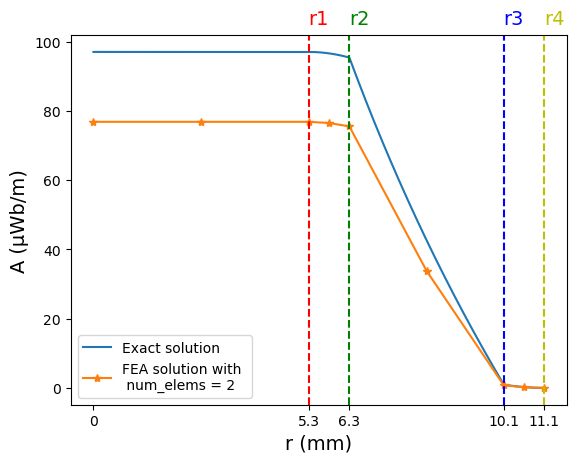

In [82]:
verbose = False
num_elems = 2

mesh_global, mesh_global_lst = creat_mesh(num_elems)
K, F, U = FEM(mesh_global_lst, verbose)
exact_func = exact_fn()
x_global = np.linspace(0, 0.0111, 5000)
interfaces_mm = []
for i in interfaces_global:
    interfaces_mm.append("{}".format(i*1000))
print(interfaces_mm)
# x_plot = mesh_global
u_exact = exact_func(x_global)


np.savez("/Users/xusenqin/Desktop/Advanced-Finite-Element-Methods/FEM_1D_TUe/datasets/Poission.npz", r=x_global, solution=u_exact)
plt.plot(x_global, u_exact, label="Exact solution") 
plt.plot(mesh_global, U, "*-", label = "FEA solution with \n num_elems = {}".format(num_elems),)

r1 = consts["r1"]
r2 = consts["r2"]
r3 = consts["r3"]
r4 = consts["r4"]
fontsize = 14
plt.axvline(x=r1, color='r', linestyle='--') 
plt.text(r1, 105, "r1", fontsize=14, color='r')
plt.axvline(x=r2, color='g', linestyle='--') 

plt.text(r2, 105, "r2", fontsize=14, color='g')
plt.axvline(x=r3, color='b', linestyle='--') 
plt.text(r3, 105, "r3", fontsize=14, color='b')
plt.axvline(x=r4, color='y', linestyle='--') 
plt.text(r4, 105, "r4", fontsize=14, color='y')
plt.xlabel("r (mm)", fontsize =fontsize)
plt.ylabel("A (µWb/m)", fontsize=fontsize)
plt.xticks(ticks=interfaces_global, labels=interfaces_mm)
# plt.ylim(0, 1)
plt.legend()
plt.savefig("FEM_{}".format(num_elems))
print("U, u_exact", U[0], u_exact[0])
np.savez("/Users/xusenqin/Desktop/Advanced-Finite-Element-Methods/FEM_1D_TUe_nutils/datasets/Poission_FEM.npz", r=mesh_global, solution=U)


In [46]:

x_global = mesh_global
u_exact = U

# Find the index where x is just below 0.0063
idx_left = np.where(x_global < 0.0101)[0][-1]
# Find the index where x is just above 0.0063
idx_right = np.where(x_global > 0.0101)[0][0]

# Calculate the derivative using finite differences
# For the left side, use the difference between the points at idx_left and idx_left-1
derivative_left = (u_exact[idx_left] - u_exact[idx_left - 1]) / (x_global[idx_left] - x_global[idx_left - 1])

# For the right side, use the difference between the points at idx_right+1 and idx_right
derivative_right = (u_exact[idx_right + 1] - u_exact[idx_right]) / (x_global[idx_right + 1] - x_global[idx_right])

derivative_left, derivative_right

(array([-17762.82847008]), array([-1085.67232588]))